In [1]:
import pyarrow.feather as feather
import pandas as pd
from datetime import datetime
import numpy as np
import math

import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt

In [2]:
df = feather.read_feather('ems_metingen_pqi.feather')
df['DATUM_TIJD'] = pd.to_datetime(df['DATUM_TIJD'])

In [3]:
print(df.columns)
df.head()

Index(['ROUTE_ID', 'ROUTE_NAAM', 'TA_B1_NAME', 'TA_B2_NAME', 'TA_B3_NAME',
       'M_POINT_P', 'M_POINT_Q', 'M_POINT_I', 'M_TIMESTAMP', 'DATUM_TIJD',
       'FLAG_P', 'FLAG_Q', 'FLAG_I', 'FLAG_MEETFOUT', 'FLAG_SCHAKEL_EVENT',
       'SCHEMA_MS_VELD_ID', 'UPDATE_DATUMTIJD', 'M_VALUE_P', 'M_VALUE_Q',
       'M_VALUE_I', 'BEDRIJFSSPANNING'],
      dtype='object')


,ROUTE_ID,ROUTE_NAAM,TA_B1_NAME,TA_B2_NAME,TA_B3_NAME,M_POINT_P,M_POINT_Q,M_POINT_I,M_TIMESTAMP,DATUM_TIJD,...,FLAG_Q,FLAG_I,FLAG_MEETFOUT,FLAG_SCHAKEL_EVENT,SCHEMA_MS_VELD_ID,UPDATE_DATUMTIJD,M_VALUE_P,M_VALUE_Q,M_VALUE_I,BEDRIJFSSPANNING
0,10347710.0,"HRVH 20-1V6, V2",HrvH,20-1i,V106,0B875,0B876,0B874,2021-05-14 18:50:00.000000000,2021-05-14 16:50:00,...,0.0,0.0,0.0,0.0,10183207.0,None,0.00,0.00,0.00,0.0210
1,2871560.0,NK 10-1V2.08,Nk,10,2.08,05814,05815,047E7,2021-10-04 18:55:00.000000000,2021-10-04 16:55:00,...,0.0,1.0,0.0,0.0,2616351.0,None,0.30,-0.11,18.14,0.0105
2,10347710.0,"HRVH 20-1V6, V2",HrvH,20-1i,V102,0B865,0B866,0B864,2021-01-13 10:00:00.000000000,2021-01-13 09:00:00,...,0.0,0.0,0.0,0.0,10183126.0,None,0.44,0.02,11.81,0.0210
3,10347790.0,GRD 10-1V17,Grd,10,V17,068A2,068AB,04E55,2021-10-03 12:20:00.000000000,2021-10-03 10:20:00,...,0.0,1.0,0.0,0.0,10266102.0,None,0.23,-0.08,13.53,0.0105
4,NaN,None,Dtn,10,INSTAL2,0221D,0221E,,2021-06-11 16:30:00.000000000,2021-06-11 14:30:00,...,0.0,0.0,0.0,0.0,NaN,None,-6.20,-5.69,NaN,0.0105


In [4]:
# preprocessing

# Dropping columns
remove_list = [0,1,5,6,7,8,10,11,12,14,15,16]
for index in remove_list:
    print('column removed ->', df.columns[index])
df = df.drop(df.columns[remove_list], axis=1)
stations = df["TA_B1_NAME"].unique()

column removed -> ROUTE_ID
column removed -> ROUTE_NAAM
column removed -> M_POINT_P
column removed -> M_POINT_Q
column removed -> M_POINT_I
column removed -> M_TIMESTAMP
column removed -> FLAG_P
column removed -> FLAG_Q
column removed -> FLAG_I
column removed -> FLAG_SCHAKEL_EVENT
column removed -> SCHEMA_MS_VELD_ID
column removed -> UPDATE_DATUMTIJD


In [46]:
temp = df[df["TA_B1_NAME"]==3]
temp["TA_B3_NAME"].unique()

array([  6,  15,  16,  32,  44,  51,  59,  60,  62,  64,  79, 110, 111],
      dtype=int64)

In [5]:
def select_stations(error, stations, df):
    accepted = []
    rejected = []
    
    for station in stations:
        station_df = df.loc[df["TA_B1_NAME"] == station]
        mean_P = station_df["M_VALUE_P"].mean()
        mean_P = abs(mean_P)
        if mean_P < error:
            accepted.append(station)
        else:
            rejected.append(station)
    print("accepted: ", accepted, " rejected: ", rejected)
    return accepted, rejected


# Calculates current from P, Q, and U
def calculate_I(P,Q,U):
    return np.sqrt(pow(P,2) + pow(Q,2)/(U*np.sqrt(3)))

# Calculate phase angle in radians
def calculate_theta(P,Q):
    if P == 0:
        theta = math.pi*0.5
    else:
        theta = math.atan(Q/P)
        
    if P < 0 & Q > 0:
        print(P,Q)
        theta += 2*math.pi
    elif Q < 0:
        theta += math.pi
    
    return theta

# converts a time amount in 'nanoseconds' to an amount in '5 minutes'
def ns_to_5m(x):
    return x/(pow(10,9)*60*5)



def fill_nan(temp_df, mean_P, mean_Q, mean_I):
    nan_df = temp_df.isna()
    
    #Check all rows where P and Q are known, but I is NaN
    nan_I = temp_df[~nan_df["M_VALUE_P"] & ~nan_df["M_VALUE_Q"] & nan_df["M_VALUE_I"]]
    pre_nans = temp_df["M_VALUE_I"].isna().sum()
    
    # Compute I from P and Q
    temp_df["M_VALUE_I"] = nan_I.apply(lambda x: calculate_I(x["M_VALUE_P"], x["M_VALUE_Q"], x["BEDRIJFSSPANNING"]), axis=1)
    post_nans = temp_df["M_VALUE_I"].isna().sum()
    print("{diff} NaN 'I' values computed from total {tot} 'I' NaNs".format(diff=abs(pre_nans-post_nans), tot = pre_nans))
    
    # Impute the rest of the NaN values with df average values
    # note to self: maybe better to use station average values for imputation
    # instead of average value across different stations
    
    pre_nans = temp_df.isna().sum().sum()
    temp_df["M_VALUE_P"] = temp_df["M_VALUE_P"].fillna(value= mean_P)
    temp_df["M_VALUE_Q"] = temp_df["M_VALUE_Q"].fillna(value= mean_Q)
    temp_df["M_VALUE_I"] = temp_df["M_VALUE_I"].fillna(value= mean_I)
    post_nans = temp_df.isna().sum().sum()
    
    print("{diff} NaN values imputed from total {tot} NaNs".format(diff=pre_nans - post_nans, tot = pre_nans))
    return temp_df

In [6]:
# sort values on "DATUM_TIJD"
df = df.sort_values("DATUM_TIJD")

# .value returns time in nanoseconds, starting form unix time.
# Get starting timestamp and convert this to '5 minutes'
start_time = ns_to_5m(df["DATUM_TIJD"].iloc[1].value)


# Convert each DATETIME timestamp to a float value representing the amount of 5 minutes since start time
df["DATUM_TIJD"] = df['DATUM_TIJD'].apply(lambda x: ns_to_5m(x.value)-start_time)

In [7]:
#Gather lists of each unique station, installation, and field
stations = df["TA_B1_NAME"].unique()
installations = df["TA_B2_NAME"].unique()
fields = df["TA_B3_NAME"].unique()

# Generate dictionaries for mapping each unqiue string to a unique integer
station_dict = dict(zip(stations, range(len(stations))))
installation_dict = dict(zip(installations, range(len(installations))))
field_dict = dict(zip(fields, range(len(fields))))

# Replace each value in the station, installation, and field column with an integer according to the column dict
df = df.replace({"TA_B1_NAME": station_dict})
df = df.replace({"TA_B2_NAME": installation_dict})
df = df.replace({"TA_B3_NAME": field_dict})

In [8]:
# Split in to test and train based on if their error is smaller than P
accepted_error = 0.5

# Get all station names
stations = df["TA_B1_NAME"].unique()

accepted_stations, rejected_stations = select_stations(accepted_error, stations, df)

# train on stations with small error, test on stations with larger error
df_test = df.loc[df["TA_B1_NAME"].isin(rejected_stations)]
df_train = df[df["TA_B1_NAME"].isin(accepted_stations)]

# Reset dataframe indices
df_test.reset_index(inplace=True)
df_train.reset_index(inplace=True)

print("Done splitting datasets")

accepted:  [0, 2, 3, 4, 5]  rejected:  [1, 6, 7, 8, 9]
Done splitting datasets


In [9]:
# Get mean values for train and test
mean_P_train = df_train["M_VALUE_P"].mean()
mean_Q_train = df_train["M_VALUE_Q"].mean()
mean_I_train = df_train["M_VALUE_I"].mean()

mean_P_test = df_test["M_VALUE_P"].mean()
mean_Q_test = df_test["M_VALUE_Q"].mean()
mean_I_test = df_test["M_VALUE_I"].mean()

In [10]:
df_train.isna().sum()

index                    0
TA_B1_NAME               0
TA_B2_NAME               0
TA_B3_NAME               0
DATUM_TIJD               0
FLAG_MEETFOUT            0
M_VALUE_P           664529
M_VALUE_Q           664530
M_VALUE_I           359143
BEDRIJFSSPANNING         0
dtype: int64

In [11]:
df_train = fill_nan(df_train, mean_P_train, mean_Q_train, mean_I_train)
df_test = fill_nan(df_test, mean_P_test, mean_Q_test, mean_I_test)

C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_I"] = nan_I.apply(lambda x: calculate_I(x["M_VALUE_P"], x["M_VALUE_Q"], x["BEDRIJFSSPANNING"]), axis=1)


7626554 NaN 'I' values computed from total 359143 'I' NaNs


C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_P"] = temp_df["M_VALUE_P"].fillna(value= mean_P)
C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_Q"] = temp_df["M_VALUE_Q"].fillna(value= mean_Q)
C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

9314756 NaN values imputed from total 9314756 NaNs


C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_I"] = nan_I.apply(lambda x: calculate_I(x["M_VALUE_P"], x["M_VALUE_Q"], x["BEDRIJFSSPANNING"]), axis=1)
C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_P"] = temp_df["M_VALUE_P"].fillna(value= mean_P)


3282191 NaN 'I' values computed from total 1240653 'I' NaNs
4691218 NaN values imputed from total 4691218 NaNs


C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_Q"] = temp_df["M_VALUE_Q"].fillna(value= mean_Q)
C:\Users\David\AppData\Local\Temp\ipykernel_15272\926067578.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["M_VALUE_I"] = temp_df["M_VALUE_I"].fillna(value= mean_I)


In [19]:
temp_subset_df = df_test[df_test['TA_B1_NAME'] == 7]
temp_subset_df.drop('index', axis=1, inplace=True)
temp_subset_df.drop('FLAG_MEETFOUT', axis=1, inplace=True)
temp_subset_df.rename(columns={"TA_B1_NAME": "substation", "TA_B2_NAME": "installation", "TA_B3_NAME": "field", "DATUM_TIJD": "timestamp", "M_VALUE_P": "P", "M_VALUE_Q": "Q", "M_VALUE_I": "I", "BEDRIJFSSPANNING": "voltage"}, inplace=True)
temp_subset_df[temp_subset_df["timestamp"]==1000]

C:\Users\David\AppData\Local\Temp\ipykernel_15272\3763944560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_subset_df.drop('index', axis=1, inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_15272\3763944560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_subset_df.drop('FLAG_MEETFOUT', axis=1, inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_15272\3763944560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,substation,installation,field,timestamp,P,Q,I,voltage
55019,7,0,25,1000.0,4.87,0.43,5.820976,0.0105
55023,7,0,30,1000.0,0.01,-0.37,2.743656,0.0105
55035,7,0,71,1000.0,0.01,0.00,98.062745,0.0105
55037,7,0,20,1000.0,0.13,-0.28,2.080332,0.0105
55045,7,0,21,1000.0,-7.74,-1.55,13.856798,0.0105


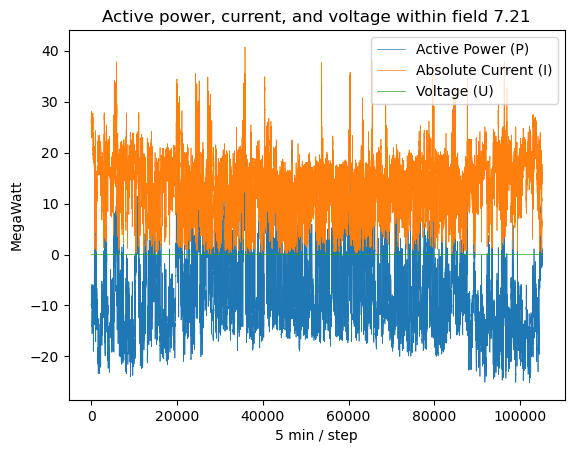

,index,TA_B1_NAME,TA_B2_NAME,TA_B3_NAME,DATUM_TIJD,FLAG_MEETFOUT,M_VALUE_P,M_VALUE_Q,M_VALUE_I,BEDRIJFSSPANNING
6,4969516,7,0,21,0.0,0.0,-9.80,3.23,25.878577,0.0105
98,4539499,7,0,21,1.0,0.0,-9.80,3.24,25.947221,0.0105
126,4560181,7,0,21,2.0,0.0,-9.92,3.23,25.924257,0.0105
174,4978754,7,0,21,3.0,0.0,-10.02,3.18,25.621050,0.0105
226,6431369,7,0,21,4.0,0.0,-9.91,3.26,26.126128,0.0105
...,...,...,...,...,...,...,...,...,...,...
5678712,14023473,7,0,21,105115.0,0.0,-0.92,2.24,16.635590,0.0105
5678791,14023305,7,0,21,105116.0,0.0,-0.74,2.16,16.033997,0.0105
5678806,14023293,7,0,21,105117.0,0.0,-0.57,2.08,15.434222,0.0105
5678875,14023266,7,0,21,105118.0,0.0,-0.22,2.00,14.832106,0.0105


In [17]:
range_start = 0
range_end = 5000000

subset_df = df_test[df_test['TA_B1_NAME'] == 7]
field_subset_df = subset_df[subset_df["TA_B3_NAME"]==21]
P_list = field_subset_df["M_VALUE_P"].tolist()[range_start:range_end]
I_list = field_subset_df["M_VALUE_I"].tolist()[range_start:range_end]
U_list = field_subset_df["BEDRIJFSSPANNING"].tolist()[range_start:range_end]
S_list = [U*I*np.sqrt(3)*100 for U,I in zip(U_list, I_list)]

plt.plot(P_list,  linewidth=0.5, label = 'Active Power (P)')
# plt.plot(S_list, linewidth=0.5, label = 'Apparent Power (S)')
plt.plot(I_list, linewidth=0.5, label = 'Absolute Current (I)')
plt.plot(U_list, linewidth=0.5, label = 'Voltage (U)')

plt.legend()
plt.title('Active power, current, and voltage within field 7.21')
plt.ylabel('MegaWatt')
plt.xlabel('5 min / step')
plt.savefig('P_plot.png')
plt.show()


field_subset_df